In [2]:
import os
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

from utils import read_intan as ri
from utils import signal_preprocessing as spp
from utils import plot_chuncked_data as pcd

Successfully imported RHD utilities


In [3]:
raw_path = './data/intan/attempt1/d0_1'
npz_path = './data/compressed/attempt1'
exp_name = raw_path.split('/')[-1]
pin_map = {
        1: 'in11', 2: 'in10', 3: 'in9', 4: 'in8',
        5: 'in23', 6: 'in22', 7: 'in21', 8: 'in20',
        9: 'in12', 10: 'in13', 11: 'in14', 12: 'in15',
        13: 'in16', 14: 'in17', 15: 'in18', 16: 'in19'
    }

In [4]:
df, metadata = ri.rhd2dataframe(raw_path, pin_map)

df.head(10)

Found 5 RHD files in ./data/intan/attempt1/d0_1
Successfully loaded data from during surgery_250609_132716.rhd
Successfully loaded data from during surgery_250609_132716.rhd
Successfully loaded data from during surgery_250609_133216.rhd
Successfully loaded data from during surgery_250609_133216.rhd
Successfully loaded data from during surgery_250609_133716.rhd
Successfully loaded data from during surgery_250609_133716.rhd
Successfully loaded data from during surgery_250609_134216.rhd
Successfully loaded data from during surgery_250609_134216.rhd
Successfully loaded data from during surgery_250609_134716.rhd
Processing 5 files with 8 channels
Channels: ['B-008', 'B-009', 'B-010', 'B-011', 'B-012', 'B-021', 'B-022', 'B-023']
Concatenating data from all files...
Successfully loaded data from during surgery_250609_134716.rhd
Processing 5 files with 8 channels
Channels: ['B-008', 'B-009', 'B-010', 'B-011', 'B-012', 'B-021', 'B-022', 'B-023']
Concatenating data from all files...
Successfully

,time,pin_4,pin_3,pin_2,pin_1,pin_9,pin_7,pin_6,pin_5
0,0.00000,-91.845,-821.535,-48.945,-122.850,-271.245,-166.530,-199.875,-180.375
1,0.00005,-263.835,-968.370,-199.485,-257.205,-399.360,-197.145,-225.810,-171.405
2,0.00010,-172.770,-887.055,-116.805,-181.740,-318.240,-146.445,-172.965,-134.355
3,0.00015,-171.405,-892.515,-120.510,-186.030,-330.720,-150.150,-175.695,-136.695
4,0.00020,-170.625,-885.690,-119.925,-181.935,-312.780,-143.325,-167.700,-129.480
5,0.00025,-170.040,-878.085,-116.805,-179.790,-311.805,-142.935,-162.240,-129.090
6,0.00030,-167.310,-875.160,-114.855,-176.670,-310.635,-141.570,-166.530,-121.290
7,0.00035,-165.165,-868.140,-114.660,-178.035,-309.660,-141.960,-165.945,-127.140
8,0.00040,-168.090,-868.530,-114.270,-175.305,-308.685,-139.815,-165.555,-126.750
9,0.00045,-167.700,-866.385,-113.880,-173.940,-307.515,-140.010,-165.360,-125.580


In [ ]:
mosaic_groups = {
    'lat': [(4, 1), (1, 5), (5, 6), (6, 7)],
    'med': [(4, 2), (2, 3), (3, 9)],
    'ref_shift': [(4, 7), (1, 7), (2, 7), (5, 7), (3, 7), (6, 7), (9, 7)]
}

df = spp.apply_common_average_reference(df)
df = spp.zscore_normalize(df)
mosaic_data = spp.get_mosaic_df(df, mosaic_groups)

Applied Common Average Reference across 8 channels


Estimated sampling rate: 20000.0 Hz
Applied zero-phase bandpass filter: 1-50 Hz
Applied zero-phase bandpass filter: 1-50 Hz
Estimated sampling rate: 20000.0 Hz
Estimated sampling rate: 20000.0 Hz
Applied zero-phase bandpass filter: 1-50 Hz
Applied zero-phase bandpass filter: 1-50 Hz
Estimated sampling rate: 20000.0 Hz
Estimated sampling rate: 20000.0 Hz
Applied zero-phase bandpass filter: 1-50 Hz
Applied zero-phase bandpass filter: 1-50 Hz


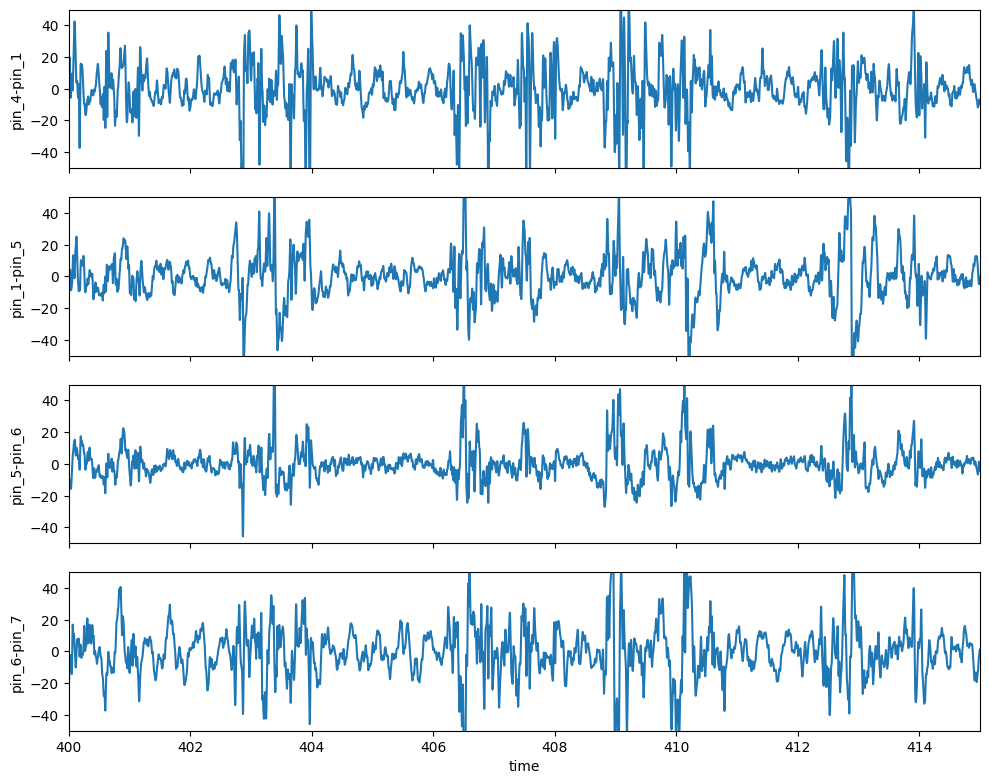

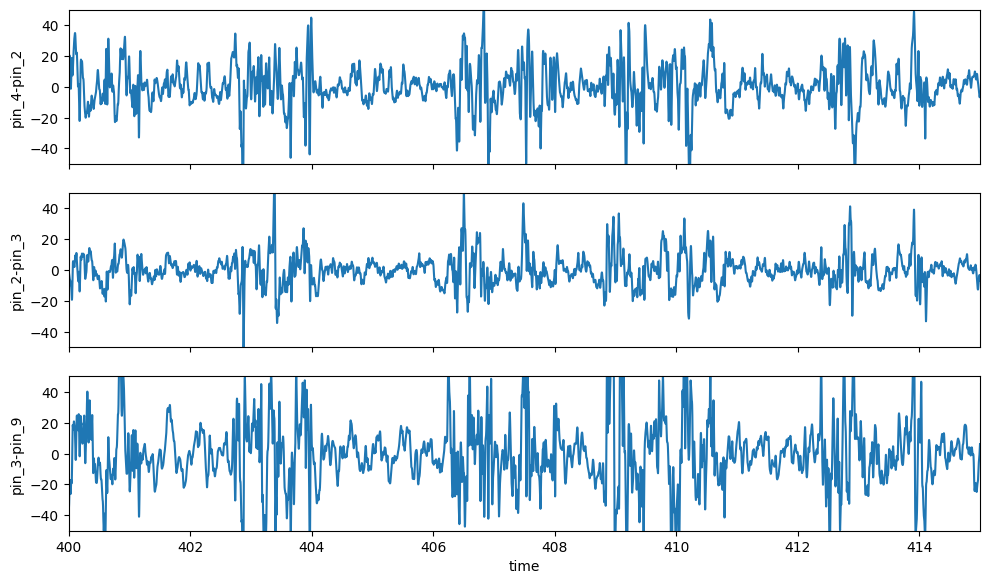

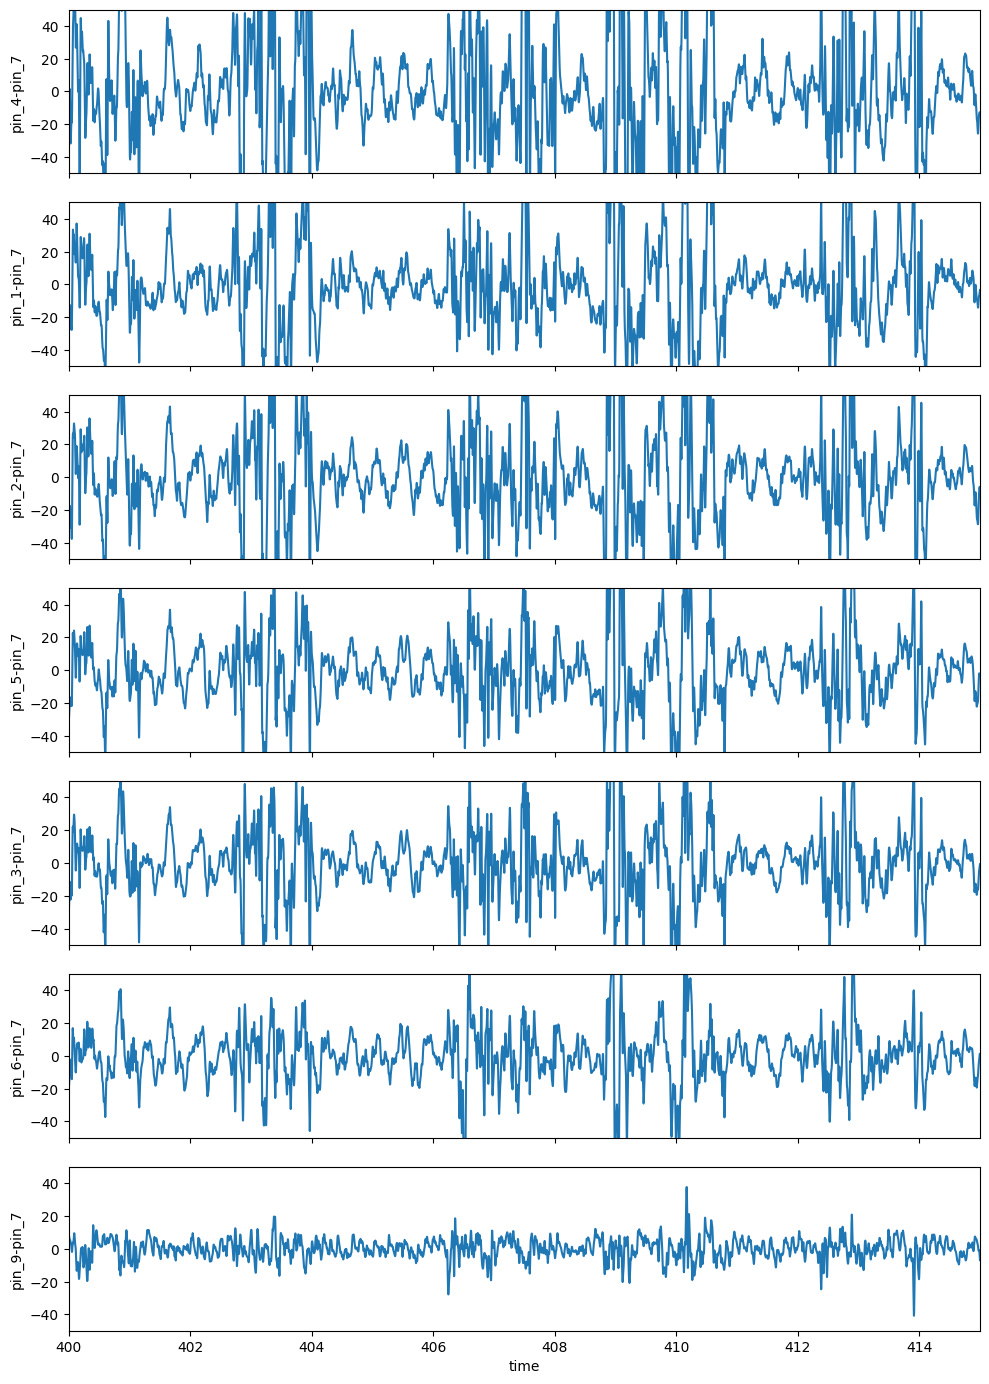

In [24]:
def plot_channels(df, time_min=None, time_max=None):
    """Plot each channel in df as a subplot with symmetric y-limits based on nearest multiple of 50 and exact x-axis range."""
    # Filter by time range if specified
    df_plot = df
    if time_min is not None:
        df_plot = df_plot[df_plot['time'] >= time_min]
    if time_max is not None:
        df_plot = df_plot[df_plot['time'] <= time_max]
    # Identify channel columns
    channels = [col for col in df_plot.columns if col != 'time']
    # Compute global min/max across all channels
    data_vals = df_plot[channels].values
    global_max = data_vals.max()
    global_min = data_vals.min()
    abs_max = max(abs(global_max), abs(global_min))
    # Round up to nearest multiple of 50 for symmetric limits
    y_limit = 50 # int(np.ceil(abs_max / 50.0) * 50)
    # Create subplots
    n_ch = len(channels)
    fig, axs = plt.subplots(n_ch, 1, sharex=True, figsize=(10, 2*n_ch))
    if n_ch == 1:
        axs = [axs]
    for ax, ch in zip(axs, channels):
        ax.plot(df_plot['time'], df_plot[ch])
        ax.set_ylim(-y_limit, y_limit)
        ax.set_ylabel(ch)
    # Set exact x-axis limits and remove padding
    x_start = time_min if time_min is not None else df_plot['time'].min()
    x_end = time_max if time_max is not None else df_plot['time'].max()
    for ax in axs:
        ax.set_xlim(x_start, x_end)
        ax.margins(x=0)
    axs[-1].set_xlabel('time')
    plt.tight_layout()
    return fig, axs

start_time = 400
duration = 15  # Duration in seconds to plot
end_time = start_time + duration

for group in list(mosaic_data.keys()):
    mosaic_df = mosaic_data[group]
    # mosaic_df = spp.remove_artifacts_hilbert_kurtosis(mosaic_df)
    mosaic_df = spp.bandpass_filter(mosaic_df, 1, 50, order=4)
    # mosaic_df = spp.resample_dataframe(mosaic_df, 1000)
    fig, axs = plot_channels(mosaic_df, start_time, end_time)
